# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


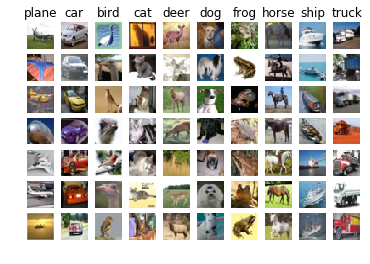

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


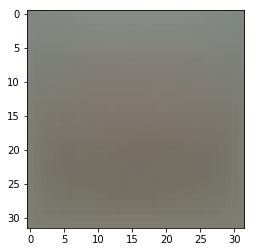

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [90]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.701604


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [91]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -15.868607 analytic: -15.868607, relative error: 1.005179e-11
numerical: -2.849646 analytic: -2.849646, relative error: 5.631440e-11
numerical: 15.182197 analytic: 15.182197, relative error: 1.345647e-11
numerical: 15.719943 analytic: 15.719943, relative error: 3.027383e-11
numerical: 3.057598 analytic: 3.057598, relative error: 5.706178e-11
numerical: -32.609194 analytic: -32.609194, relative error: 2.018811e-12
numerical: 3.622324 analytic: 3.622324, relative error: 1.410176e-11
numerical: -5.779171 analytic: -5.779171, relative error: 2.533301e-11
numerical: 16.594942 analytic: 16.594942, relative error: 9.513042e-12
numerical: -4.362568 analytic: -4.362568, relative error: 1.085748e-10
numerical: -22.385650 analytic: -22.385650, relative error: 1.510133e-11
numerical: -0.009031 analytic: -0.009031, relative error: 7.423793e-09
numerical: 16.760676 analytic: 16.760676, relative error: 1.237592e-11
numerical: -9.591335 analytic: -9.591335, relative error: 3.961150e-12
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [92]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.701604e+00 computed in 0.075499s
Vectorized loss: 8.701604e+00 computed in 0.007640s
difference: 0.000000


In [93]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.074128s
Vectorized loss and gradient: computed in 0.005740s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [94]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 797.680935
iteration 100 / 1500: loss 289.003745
iteration 200 / 1500: loss 109.513478
iteration 300 / 1500: loss 42.247332
iteration 400 / 1500: loss 18.402183
iteration 500 / 1500: loss 10.367959
iteration 600 / 1500: loss 7.249845
iteration 700 / 1500: loss 5.966757
iteration 800 / 1500: loss 5.553853
iteration 900 / 1500: loss 5.467728
iteration 1000 / 1500: loss 5.251157
iteration 1100 / 1500: loss 5.064352
iteration 1200 / 1500: loss 5.582881
iteration 1300 / 1500: loss 4.942125
iteration 1400 / 1500: loss 5.431501
That took 7.296022s


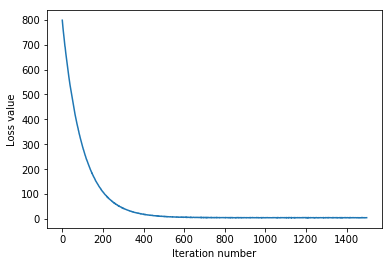

In [95]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [96]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370061
validation accuracy: 0.372000


In [67]:
import numpy
with numpy.errstate(divide='ignore'):
    numpy.float64(1.0) / 0.0

In [102]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
svm = LinearSVM()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        
        y_train_pred = svm.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

25000.0
0.031002413440157035
25000.0
0.03069012695544373
25000.0
0.030380652649127062
25000.0
0.030074808497114035
25000.0
0.029771848907071873
25000.0
0.029472116372411532
25000.0
0.029175144141143906
25000.0
0.02888156304823971
25000.0
0.028590684353552547
25000.0
0.02830306680369043
25000.0
0.02801854436656712
25000.0
0.027736761763673994
25000.0
0.027457974259223313
25000.0
0.02718211517723546
25000.0
0.026908398091784923
25000.0
0.026638089624101177
25000.0
0.02637036488668215
25000.0
0.026105356313653478
25000.0
0.025842708410854648
25000.0
0.02558282320836936
25000.0
0.025325616650336648
25000.0
0.025071387792458863
25000.0
0.024819196371803843
25000.0
0.02457001289581641
25000.0
0.02432312821718736
25000.0
0.024078700061321172
25000.0
0.023836861228523347
25000.0
0.0235971478706503
25000.0
0.023360045504395077
25000.0
0.023125245456075784
25000.0
0.022893049542749656
25000.0
0.022663239528412794
25000.0
0.02243556516930431
25000.0
0.022210377543669217
25000.0
0.0219872489272015

25000.0
0.001413135308310691
25000.0
0.0013991856044615393
25000.0
0.0013853469190150355
25000.0
0.0013715461852313185
25000.0
0.001357971894582277
25000.0
0.0013445105667656745
25000.0
0.0013312199687301987
25000.0
0.0013179796512946163
25000.0
0.0013048423351566607
25000.0
0.0012919153752323903
25000.0
0.0012791637466719919
25000.0
0.0012664639884751537
25000.0
0.0012539268483225561
25000.0
0.0012415178174850555
25000.0
0.001229205739353751
25000.0
0.001217038381449241
25000.0
0.001204993986939359
25000.0
0.0011930164262566813
25000.0
0.0011812485526660108
25000.0
0.0011695496568625184
25000.0
0.001157965152862989
25000.0
0.0011465493595956195
25000.0
0.0011352420767623186
25000.0
0.001124099714580758
25000.0
0.0011130199839120536
25000.0
0.0011020297538050735
25000.0
0.0010911872899986102
25000.0
0.0010804642101584058
25000.0
0.0010697999446469153
25000.0
0.0010592033616561355
25000.0
0.0010487642747760875
25000.0
0.0010383460683231563
25000.0
0.0010280887656689151
25000.0
0.0010178

25000.0
8.179109193465108e-05
25000.0
8.116543258925062e-05
25000.0
8.055128353476599e-05
25000.0
7.994938654744716e-05
25000.0
7.934804043157389e-05
25000.0
7.874760446533848e-05
25000.0
7.814570948977545e-05
25000.0
7.750247894641426e-05
25000.0
7.697727365029453e-05
25000.0
7.637690137496896e-05
25000.0
7.574813984162452e-05
25000.0
7.51754395073285e-05
25000.0
7.457923581931256e-05
25000.0
7.393555329818799e-05
25000.0
7.336272613439525e-05
25000.0
7.279567514291508e-05
25000.0
7.228099992140318e-05
25000.0
7.17058921523699e-05
25000.0
7.11889427458442e-05
25000.0
7.066695407408841e-05
25000.0
7.013396430262347e-05
25000.0
6.962883023887947e-05
25000.0
6.913794933014025e-05
25000.0
6.863988930910606e-05
25000.0
6.814374459536864e-05
25000.0
6.769789845859894e-05
25000.0
6.721257420929668e-05
25000.0
6.665129220254974e-05
25000.0
6.604940263492227e-05
25000.0
6.560254307252987e-05
25000.0
6.517700437954858e-05
25000.0
6.471123220561961e-05
25000.0
6.427531973597079e-05
25000.0
6.378

25000.0
2.162240524048579e-05
25000.0
2.1614028321823057e-05
25000.0
2.1659906739866124e-05
25000.0
2.1631360426828157e-05
25000.0
2.1617599367575347e-05
25000.0
2.1584616096103122e-05
25000.0
2.159721589935677e-05
25000.0
2.156354637546615e-05
25000.0
2.1539129979888826e-05
25000.0
2.1510194460974798e-05
25000.0
2.151496230734347e-05
25000.0
2.1386679317227804e-05
25000.0
2.1359841904545028e-05
25000.0
2.1373519078504382e-05
25000.0
2.1354160699756025e-05
25000.0
2.1221115946028358e-05
25000.0
2.118346449575658e-05
25000.0
2.1130803266478967e-05
25000.0
2.1093930561357608e-05
25000.0
2.1076492566858205e-05
25000.0
2.1013140444619374e-05
25000.0
2.099011338189522e-05
25000.0
2.100468435395014e-05
25000.0
2.0994324478879603e-05
25000.0
2.098215640849476e-05
25000.0
2.098034409121351e-05
25000.0
2.0900028848067442e-05
25000.0
2.0871062179381405e-05
25000.0
2.0814997363873067e-05
25000.0
2.0768519305134147e-05
25000.0
2.0722708495928974e-05
25000.0
2.0692453427458792e-05
25000.0
2.0540154

25000.0
1.8528511667701528e-05
25000.0
1.8494938591607376e-05
25000.0
1.8471694732564605e-05
25000.0
1.8459475694453623e-05
25000.0
1.8516842478511115e-05
25000.0
1.8568882797828585e-05
25000.0
1.8573448496026653e-05
25000.0
1.8564585743911532e-05
25000.0
1.8567177362776454e-05
25000.0
1.861201080868011e-05
25000.0
1.858886481904043e-05
25000.0
1.854308556723503e-05
25000.0
1.8495810274058795e-05
25000.0
1.848066987077141e-05
25000.0
1.8479857132885827e-05
25000.0
1.8400259805519034e-05
25000.0
1.843358999048888e-05
25000.0
1.840877562812463e-05
25000.0
1.8358256254580912e-05
25000.0
1.8377421485615483e-05
25000.0
1.836503218317136e-05
25000.0
1.8288163398092296e-05
25000.0
1.8324393214415194e-05
25000.0
1.834381982000955e-05
25000.0
1.8332918145008427e-05
25000.0
1.8317995886776332e-05
25000.0
1.8347945451272677e-05
25000.0
1.839470874495896e-05
25000.0
1.836792850621211e-05
25000.0
1.841266092407719e-05
25000.0
1.8349576078852644e-05
25000.0
1.831468813280653e-05
25000.0
1.8305698429

50000.0
1.838511535599291e-05
50000.0
1.8204577537343552e-05
50000.0
1.8021819016608337e-05
50000.0
1.7914905551364195e-05
50000.0
1.7736187961173384e-05
50000.0
1.7549693903360384e-05
50000.0
1.7439276079115054e-05
50000.0
1.7255672271246687e-05
50000.0
1.7175069814833975e-05
50000.0
1.7046538590618802e-05
50000.0
1.6814844172374943e-05
50000.0
1.6647071232921056e-05
50000.0
1.6496275989397025e-05
50000.0
1.634330227351633e-05
50000.0
1.6225564276881014e-05
50000.0
1.611964991220933e-05
50000.0
1.603737518990335e-05
50000.0
1.5964222099998073e-05
50000.0
1.5833299889591437e-05
50000.0
1.5738819677497285e-05
50000.0
1.5660263390513646e-05
50000.0
1.55643862037159e-05
50000.0
1.54549643406606e-05
50000.0
1.533121264405554e-05
50000.0
1.5275619954734882e-05
50000.0
1.5197182080898672e-05
50000.0
1.511530957897004e-05
50000.0
1.5020634952287395e-05
50000.0
1.4933529240224613e-05
50000.0
1.4904577429483558e-05
50000.0
1.4788794181215147e-05
50000.0
1.4679974366249683e-05
50000.0
1.46317115

50000.0
1.0895330256430376e-05
50000.0
1.0891331437362227e-05
50000.0
1.0899209152885144e-05
50000.0
1.0885419320616068e-05
50000.0
1.084684573784231e-05
50000.0
1.0810119592874064e-05
50000.0
1.0817134951971042e-05
50000.0
1.083615741562918e-05
50000.0
1.0804073845636388e-05
50000.0
1.0828272191023329e-05
50000.0
1.0763627259404057e-05
50000.0
1.0758910171104393e-05
50000.0
1.073771635095964e-05
50000.0
1.0735618129710196e-05
50000.0
1.0739460771497204e-05
50000.0
1.072713113453806e-05
50000.0
1.068723155783885e-05
50000.0
1.0717972517234247e-05
50000.0
1.0818302380693383e-05
50000.0
1.0898766147264716e-05
50000.0
1.090522541100235e-05
50000.0
1.090046951543134e-05
50000.0
1.0891812484794438e-05
50000.0
1.089728699111201e-05
50000.0
1.0979294291993921e-05
50000.0
1.0942696195720988e-05
50000.0
1.0960409401996432e-05
50000.0
1.0972937961660704e-05
50000.0
1.1017284274806087e-05
50000.0
1.1023061553540007e-05
50000.0
1.1088624093445976e-05
50000.0
1.108908927920343e-05
50000.0
1.1110917

50000.0
1.0561066839841681e-05
50000.0
1.0635985541178042e-05
50000.0
1.0648853331810272e-05
50000.0
1.067506344893961e-05
50000.0
1.0692125339169425e-05
50000.0
1.0711070029109086e-05
50000.0
1.0695671385917546e-05
50000.0
1.0733338518249867e-05
50000.0
1.0764492338604072e-05
50000.0
1.0800846929504785e-05
50000.0
1.0768234410182484e-05
50000.0
1.0750405744679068e-05
50000.0
1.0789120973519494e-05
50000.0
1.0782822727022266e-05
50000.0
1.0771300017307322e-05
50000.0
1.0775146805390016e-05
50000.0
1.078125314248822e-05
50000.0
1.0793456216686295e-05
50000.0
1.0820912698717637e-05
50000.0
1.0838822626965016e-05
50000.0
1.087205423132389e-05
50000.0
1.086650829613023e-05
50000.0
1.0837824978376223e-05
50000.0
1.0842399599881908e-05
50000.0
1.0886115596425483e-05
50000.0
1.0952183053002208e-05
50000.0
1.0937930766781996e-05
50000.0
1.0865711161825724e-05
50000.0
1.0756370258720893e-05
50000.0
1.076950823799834e-05
50000.0
1.0870598399286209e-05
50000.0
1.0959871683450011e-05
50000.0
1.100

50000.0
1.0709029241240063e-05
50000.0
1.0725704920086416e-05
50000.0
1.0759171695008542e-05
50000.0
1.0718428023933811e-05
50000.0
1.0752925546253416e-05
50000.0
1.0752585358912727e-05
50000.0
1.07135893840591e-05
50000.0
1.0689944617615687e-05
50000.0
1.0683708112491474e-05
50000.0
1.0710202697047807e-05
50000.0
1.0735446219167728e-05
50000.0
1.0740504068849512e-05
50000.0
1.0744271701209797e-05
50000.0
1.0740333310800759e-05
50000.0
1.073391166943377e-05
50000.0
1.0753974835644643e-05
50000.0
1.077240262060812e-05
50000.0
1.0805739867383812e-05
50000.0
1.068513906762067e-05
50000.0
1.069373559044592e-05
50000.0
1.0689813653548419e-05
50000.0
1.0687480337226098e-05
50000.0
1.0621292125952574e-05
50000.0
1.056095940075108e-05
50000.0
1.0589192063242185e-05
50000.0
1.0603784091220066e-05
50000.0
1.0590152362859154e-05
50000.0
1.0628376168692735e-05
50000.0
1.0574369236344881e-05
50000.0
1.0584637554864446e-05
50000.0
1.0564863242171026e-05
50000.0
1.0649203999072645e-05
50000.0
1.06688

50000.0
1.0835721782921292e-05
50000.0
1.082247635255503e-05
50000.0
1.0797201243568186e-05
50000.0
1.0836960630824818e-05
50000.0
1.0824314233322737e-05
50000.0
1.0837354130908623e-05
50000.0
1.0773369783478298e-05
50000.0
1.0793421258897152e-05
50000.0
1.0816804089459e-05
50000.0
1.0835397342719695e-05
50000.0
1.0789631990705797e-05
50000.0
1.0799851969346172e-05
50000.0
1.0801232010815162e-05
50000.0
1.0723246423215225e-05
50000.0
1.0751374276008516e-05
50000.0
1.0728352209602161e-05
50000.0
1.0673382669226118e-05
50000.0
1.0722584247735674e-05
50000.0
1.0729850147510229e-05
50000.0
1.0715547007081034e-05
50000.0
1.0709705549294218e-05
50000.0
1.078329396625173e-05
50000.0
1.08744524485765e-05
50000.0
1.0869893459057761e-05
50000.0
1.0877349943316527e-05
50000.0
1.0887979307511223e-05
50000.0
1.0938276258994075e-05
50000.0
1.0944471773365842e-05
50000.0
1.0862883397121906e-05
50000.0
1.0843721307648452e-05
50000.0
1.0806921932180633e-05
50000.0
1.0829698943374543e-05
50000.0
1.08099

50000.0
1.0888902411941676e-05
50000.0
1.0931187748068673e-05
50000.0
1.0959678724893843e-05
50000.0
1.0976820874032313e-05
50000.0
1.0958101515589608e-05
50000.0
1.0956017308823327e-05
50000.0
1.0990181593446665e-05
50000.0
1.1015789144480902e-05
50000.0
1.101598458081448e-05
50000.0
1.1115181325826247e-05
50000.0
1.111905120567387e-05
50000.0
1.1112576601029785e-05
50000.0
1.1090622743454145e-05
50000.0
1.1064498946556672e-05
50000.0
1.0952934319318395e-05
50000.0
1.0961335409034448e-05
50000.0
1.1021178316296941e-05
50000.0
1.1021405476257905e-05
50000.0
1.1018269897395684e-05
50000.0
1.1067004961076452e-05
50000.0
1.1009823917586459e-05
50000.0
1.1001468894152694e-05
50000.0
1.1005876211993117e-05
50000.0
1.0957655351259063e-05
50000.0
1.10068658836483e-05
50000.0
1.0990641327434145e-05
50000.0
1.1013133930149548e-05
50000.0
1.1059898871339825e-05
50000.0
1.1025541970029194e-05
50000.0
1.1055286662300209e-05
50000.0
1.1032526367913305e-05
50000.0
1.1071718065751043e-05
50000.0
1.10

25000.0
1.3793279046848672e+92
25000.0
3.103487785540952e+92
25000.0
6.982847517467143e+92
25000.0
1.5711406914301072e+93
25000.0
3.5350665557177426e+93
25000.0
7.953899750364923e+93
25000.0
1.7896274438321075e+94
25000.0
4.026661748622243e+94
25000.0
9.059988934400046e+94
25000.0
2.038497510240011e+95
25000.0
4.586619398040025e+95
25000.0
1.031989364559006e+96
25000.0
2.3219760702577638e+96
25000.0
5.224446158079969e+96
25000.0
1.1755003855679933e+97
25000.0
2.644875867527985e+97
25000.0
5.9509707019379675e+97
25000.0
1.338968407936043e+98
25000.0
3.012678917856097e+98
25000.0
6.77852756517622e+98
25000.0
1.5251687021646497e+99
25000.0
3.431629579870463e+99
25000.0
7.721166554708542e+99
25000.0
1.7372624748094223e+100
25000.0
3.9088405683212e+100
25000.0
8.794891278722702e+100
25000.0
1.9788505377126084e+101
25000.0
4.452413709853369e+101
25000.0
1.0017930847170083e+102
25000.0
2.254034440613269e+102
25000.0
5.071577491379856e+102
25000.0
1.1411049355604678e+103
25000.0
2.567486105011

25000.0
7.529478444204816e+186
25000.0
1.694132649946084e+187
25000.0
3.8117984623786895e+187
25000.0
8.576546540352053e+187
25000.0
1.929722971579212e+188
25000.0
4.341876686053228e+188
25000.0
9.769222543619764e+188
25000.0
2.1980750723144472e+189
25000.0
4.945668912707507e+189
25000.0
1.1127755053591894e+190
25000.0
2.503744887058176e+190
25000.0
5.633425995880898e+190
25000.0
1.267520849073202e+191
25000.0
2.8519219104147054e+191
25000.0
6.416824298433087e+191
25000.0
1.443785467147445e+192
25000.0
3.2485173010817523e+192
25000.0
7.309163927433943e+192
25000.0
1.6445618836726373e+193
25000.0
3.700264238263434e+193
25000.0
8.325594536092729e+193
25000.0
1.8732587706208647e+194
25000.0
4.214832233896945e+194
25000.0
9.483372526268129e+194
25000.0
2.133758818410329e+195
25000.0
4.800957341423242e+195
25000.0
1.0802154018202296e+196
25000.0
2.430484654095517e+196
25000.0
5.468590471714914e+196
25000.0
1.2304328561358558e+197
25000.0
2.7684739263056762e+197
25000.0
6.229066334187773e+19

25000.0
2.0199011217881399e+288
25000.0
4.5447775240233165e+288
25000.0
1.0225749429052464e+289
25000.0
2.3007936215368044e+289
25000.0
5.17678564845781e+289
25000.0
1.1647767709030077e+290
25000.0
2.6207477345317674e+290
25000.0
5.8966824026964774e+290
25000.0
1.3267535406067077e+291
25000.0
2.9851954663650925e+291
25000.0
6.716689799321461e+291
25000.0
1.511255204847329e+292
25000.0
3.4003242109064905e+292
25000.0
7.650729474539604e+292
25000.0
1.7214141317714113e+293
25000.0
3.873181796485676e+293
25000.0
8.714659042092772e+293
25000.0
1.9607982844708738e+294
25000.0
4.411796140059467e+294
25000.0
9.926541315133803e+294
25000.0
2.233471795905106e+295
25000.0
5.025311540786489e+295
25000.0
1.1306950966769602e+296
25000.0
2.544063967523161e+296
25000.0
5.724143926927113e+296
25000.0
1.2879323835586007e+297
25000.0
2.897847863006852e+297
25000.0
6.520157691765418e+297
25000.0
1.4670354806472196e+298
25000.0
3.3008298314562443e+298
25000.0
7.42686712077655e+298
25000.0
1.671045102174723

/Users/yunho/projects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:118: RuntimeWarning: overflow encountered in double_scalars
  # Implement a vectorized version of the gradient for the structured SVM     #
/Users/yunho/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/yunho/projects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:117: RuntimeWarning: overflow encountered in multiply
  # TODO:                                                                     #
/Users/yunho/projects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:118: RuntimeWarning: overflow encountered in multiply
  # Implement a vectorized version of the gradient for the structured SVM     #


25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
25000.0
inf
2500

/Users/yunho/projects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:100: RuntimeWarning: overflow encountered in add
  #? for correct scores not to contribute to loss function
/Users/yunho/projects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:100: RuntimeWarning: invalid value encountered in add
  #? for correct scores not to contribute to loss function
/Users/yunho/projects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:149: RuntimeWarning: invalid value encountered in greater
/Users/yunho/projects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:153: RuntimeWarning: overflow encountered in multiply
/Users/yunho/projects/cs231n/assignment1/cs231n/classifiers/linear_classifier.py:75: RuntimeWarning: invalid value encountered in add
  self.W += -learning_rate * grad


50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
5000

50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
50000.0
nan
5000

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.372449 val accuracy: 0.383000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.349857 val accuracy: 0.361000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.161408 val accuracy: 0.151000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.383000


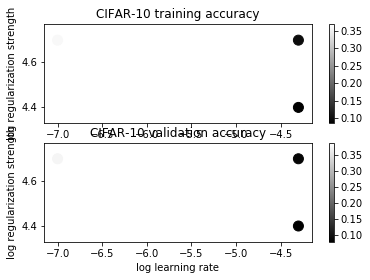

In [98]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [99]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.103000


/Users/yunho/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/yunho/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


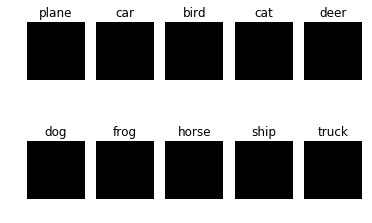

In [100]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*